In [108]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

from Data import Data

In [109]:
base_path = '/home/aacastro/Alejandro/DQ_ACA_2024/A/ZN_1D_imgs/orig/'
data_processor = Data(base_path)
X, Y, ass_f, ass_l = data_processor.get_data('train.npz', 'validation.npz', 'test.npz', 'assess.npz')
Y = np.argmax(Y, axis=1)

In [110]:
X_flattened = X.reshape(4482, 264 * 18)
X_flattened= pd.DataFrame(X_flattened)

ass_f_flattened = ass_f.reshape(60, 264 * 18)
ass_f_flattened= pd.DataFrame(ass_f_flattened)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)
ass_f_scaled = scaler.fit_transform(ass_f_flattened)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
ass_f_pca = pca.fit_transform(ass_f_scaled)

umap_model_euc = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean', random_state=42)
X_umap_euc = umap_model_euc.fit_transform(X_pca)
ass_f_umap_euc = umap_model_euc.fit_transform(ass_f_pca)

umap_model_man = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='manhattan', random_state=42)
X_umap_man = umap_model_man.fit_transform(X_pca)
ass_f_umap_man = umap_model_man.fit_transform(ass_f_pca)

umap_model_cheb = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='chebyshev', random_state=42)
X_umap_cheb = umap_model_cheb.fit_transform(X_pca)
ass_f_umap_cheb = umap_model_cheb.fit_transform(ass_f_pca)

umap_model_min = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='minkowski', random_state=42)
X_umap_min = umap_model_min.fit_transform(X_pca)
ass_f_umap_min = umap_model_min.fit_transform(ass_f_pca)

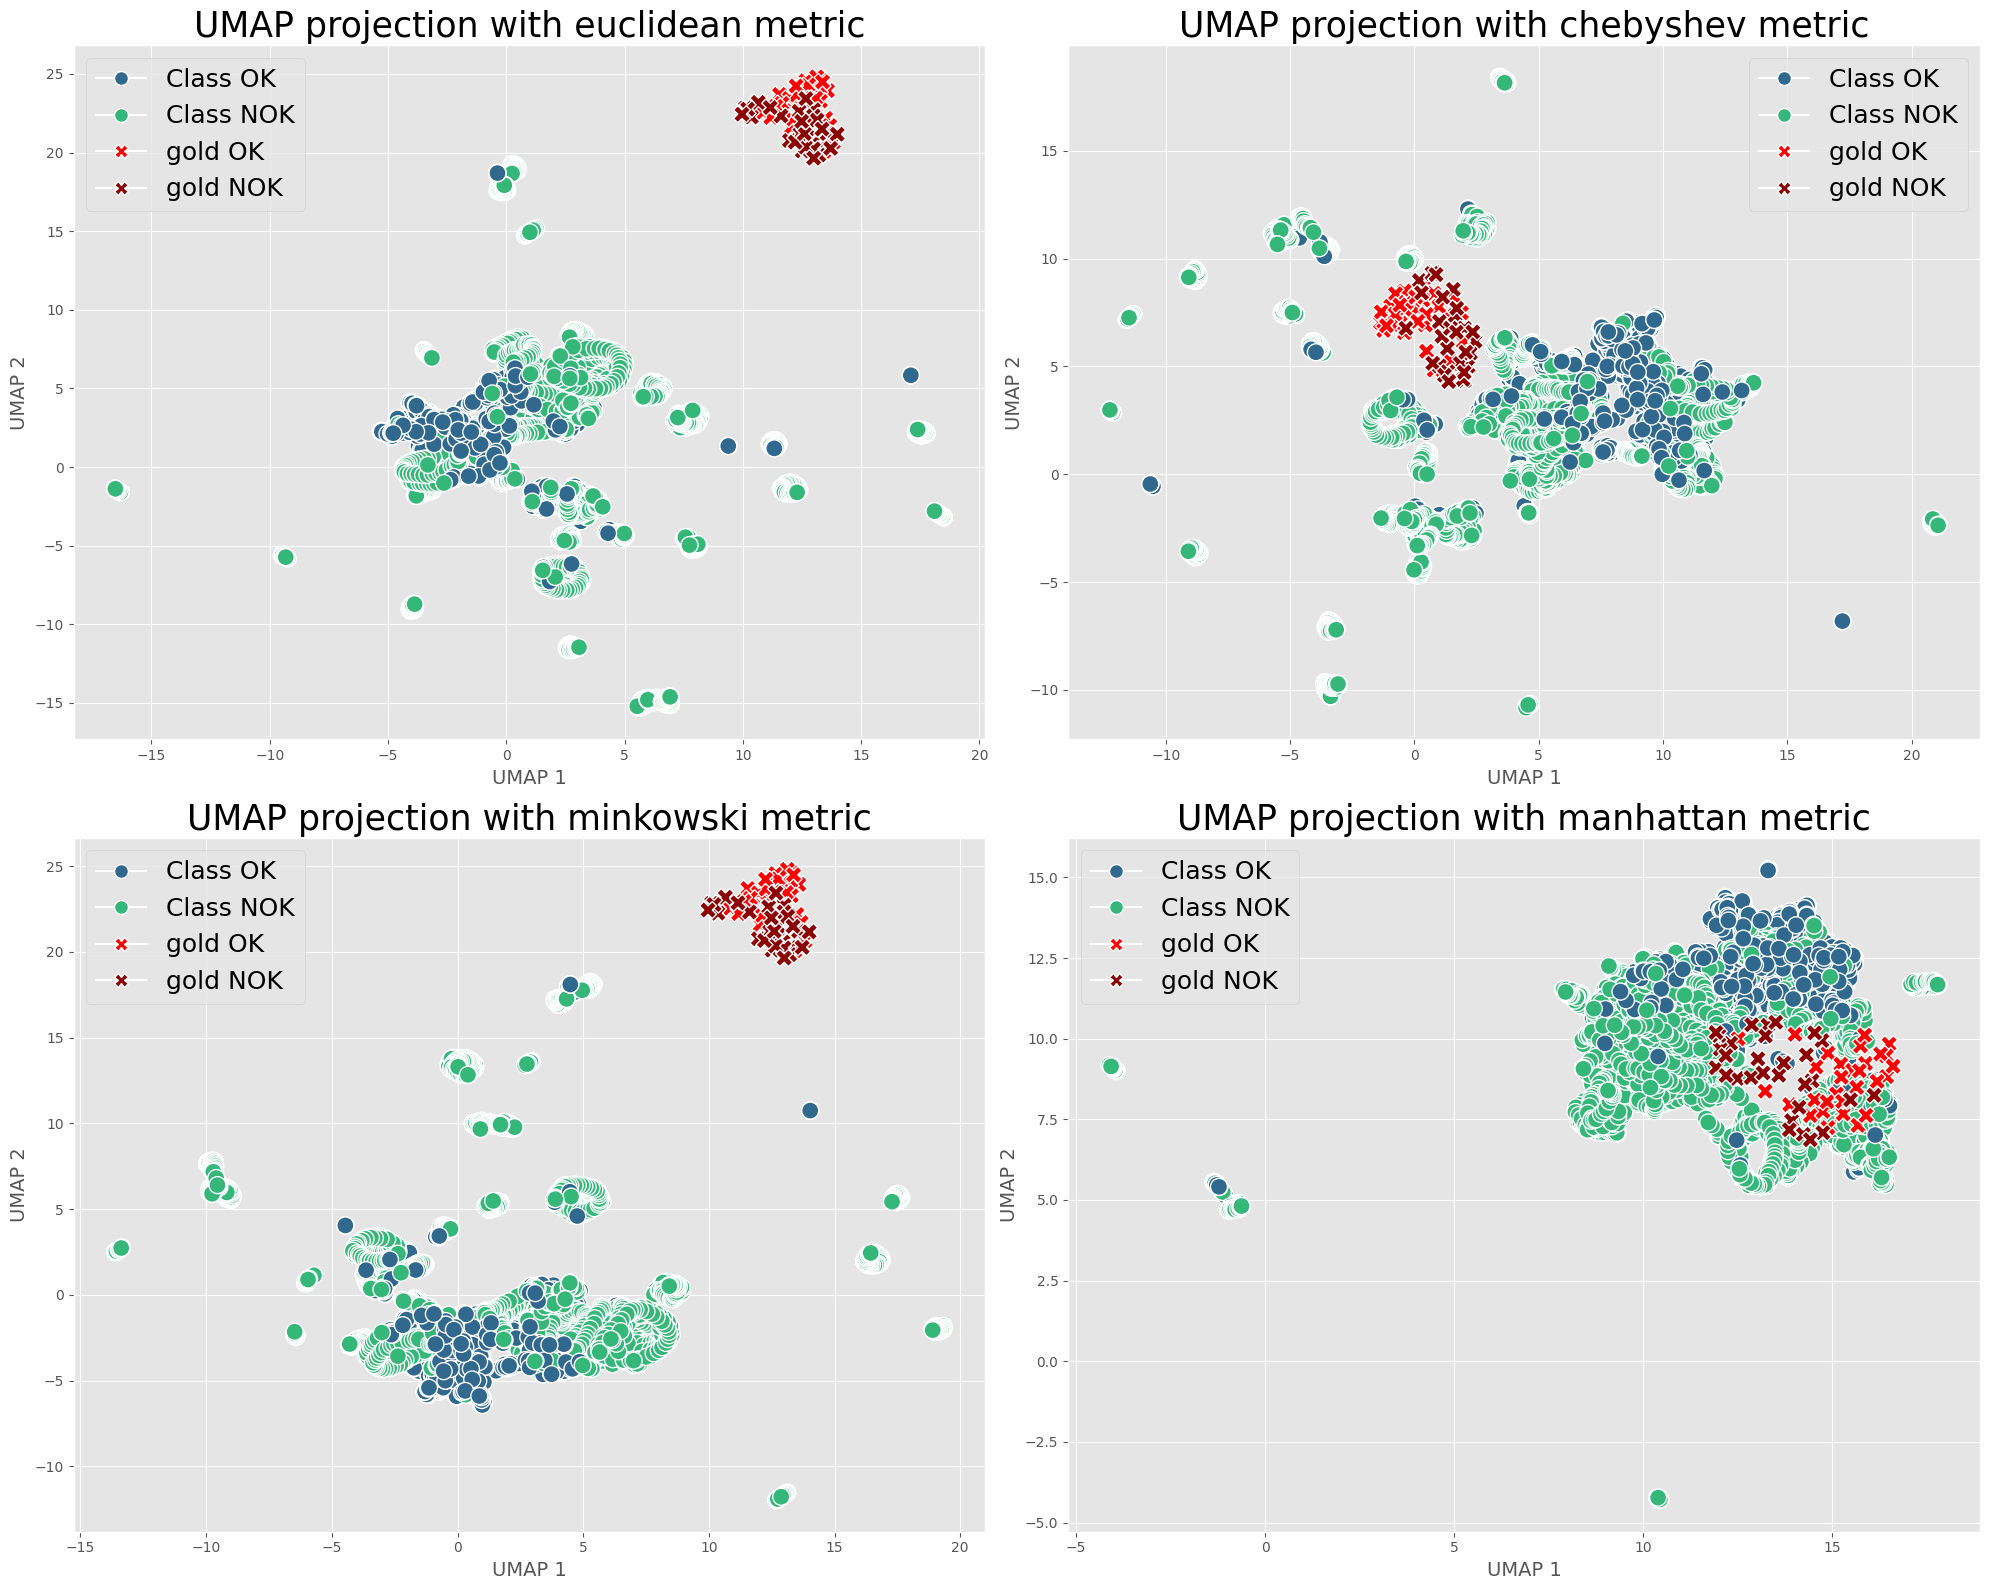

In [145]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Lista de proyecciones UMAP y sus correspondientes métricas
umap_projections = [
    (X_umap_euc, ass_f_umap_euc, 'euclidean'),
    (X_umap_cheb, ass_f_umap_cheb, 'chebyshev'),
    (X_umap_min, ass_f_umap_min, 'minkowski'),
    (X_umap_man, ass_f_umap_man, 'manhattan')
]
palette = sns.color_palette('viridis', n_colors=2)

# Iterar sobre las proyecciones y los subgráficos
for ax, (X_umap, ass_f_umap, metric) in zip(axes.flatten(), umap_projections):
    # Graficar el conjunto original
    scatter_orig = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=Y, palette='viridis', s=150, ax=ax, legend=False)
    # Graficar el nuevo conjunto `ass_f` en color rojo con cruces
    scatter_ass_f = sns.scatterplot(x=ass_f_umap[:, 0], y=ass_f_umap[:, 1], hue=ass_l, palette=['red', 'darkred'], s=150, ax=ax, marker='X', legend=False)
    
    ax.set_title(f'UMAP projection with {metric} metric', fontsize=25)
    ax.set_xlabel('UMAP 1', fontsize=14)
    ax.set_ylabel('UMAP 2', fontsize=14)
    # palette = 'viridis'

    # Crear una leyenda personalizada
    handles_orig = [
        plt.Line2D([0], [0], marker='o', color='w', label='Class OK', markerfacecolor=palette[0], markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Class NOK', markerfacecolor=palette[1], markersize=10)
    ]
    
    handles_ass_f = [
        plt.Line2D([0], [0], marker='X', color='w', label='gold OK', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='X', color='w', label='gold NOK', markerfacecolor='darkred', markersize=10)
    ]
    
    handles_combined = handles_orig + handles_ass_f
    ax.legend(handles=handles_combined, fontsize=18)

plt.tight_layout()
plt.show()

# OK Cluster

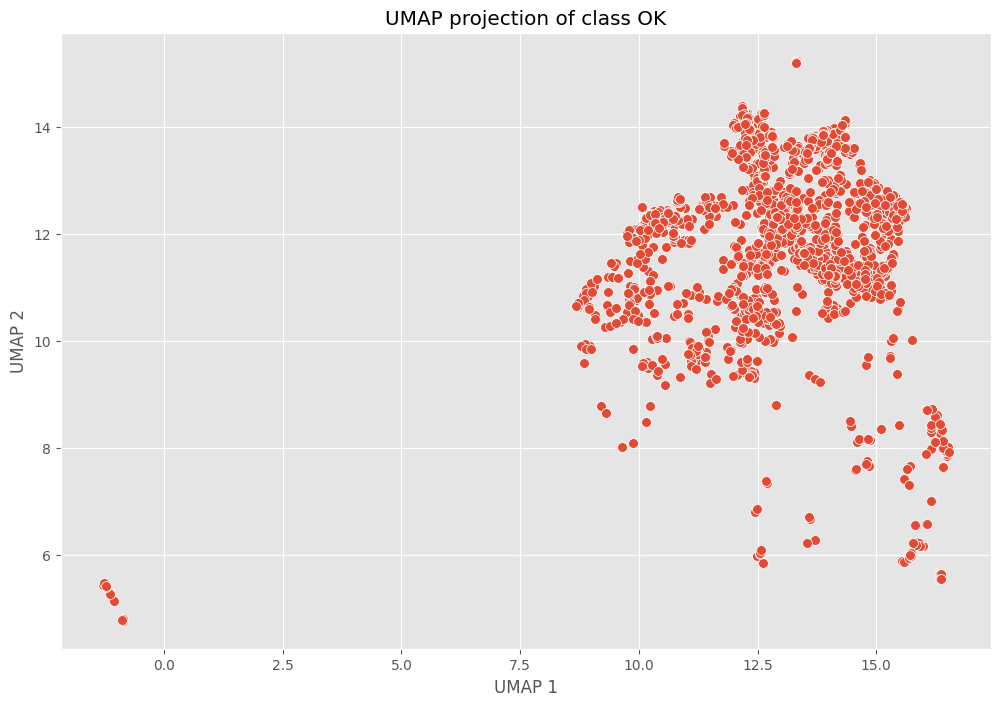

In [129]:
X_cluster_0 = X_umap[Y == 0]

# Graficar la clase 0
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], palette='viridis', s=50)
plt.title('UMAP projection of class OK')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

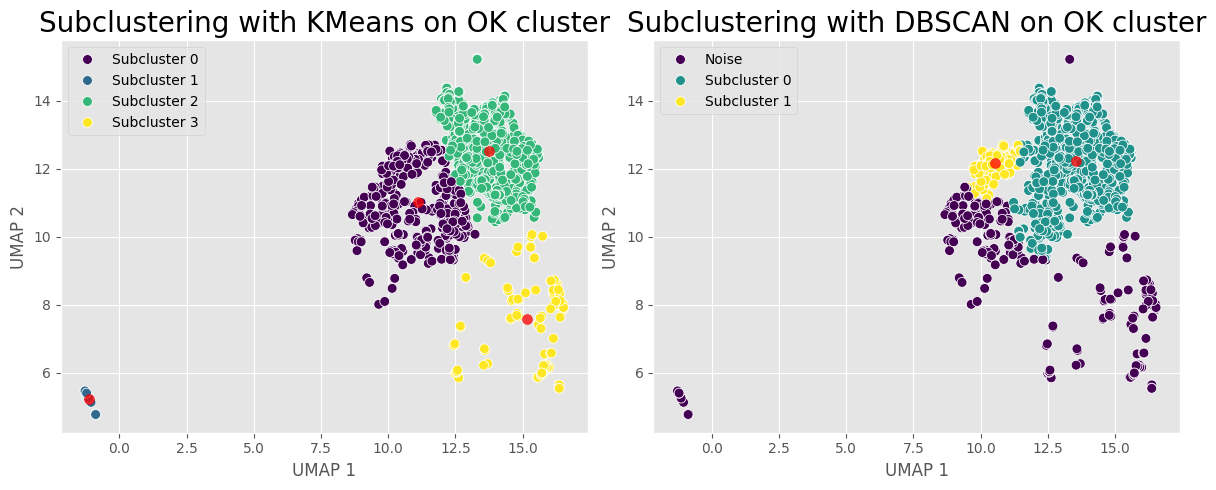

In [178]:
# Definir el número de clusters para KMeans
n_clusters_kmeans = 4  # Ajusta este valor según tus necesidades

# Crear el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_cluster_0)
centroids_kmeans = kmeans.cluster_centers_

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=70)  # Ajusta estos parámetros según tus necesidades
clusters_dbscan = dbscan.fit_predict(X_cluster_0)

# Obtener los baricentros de los clusters de DBSCAN (no todos los clusters tienen baricentros en DBSCAN)
centroids_dbscan = []
for label in set(clusters_dbscan):
    if label != -1:  # El cluster -1 en DBSCAN representa puntos ruido
        cluster_points = X_cluster_0[clusters_dbscan == label]
        centroid = cluster_points.mean(axis=0)
        centroids_dbscan.append(centroid)
centroids_dbscan = np.array(centroids_dbscan)

# Visualizar los resultados de KMeans y DBSCAN
plt.figure(figsize=(12, 5))

# Gráfico de KMeans
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], hue=clusters_kmeans, palette='viridis', s=50)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering with KMeans on OK cluster', fontsize=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Personalizar leyenda de KMeans
handles, labels = plt.gca().get_legend_handles_labels()
labels_kmeans = [f'Subcluster {label}' for label in range(n_clusters_kmeans)]
plt.legend(handles, labels_kmeans)

# Gráfico de DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_cluster_0[:, 0], y=X_cluster_0[:, 1], hue=clusters_dbscan, palette='viridis', s=50)
if len(centroids_dbscan) > 0:
    plt.scatter(centroids_dbscan[:, 0], centroids_dbscan[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering with DBSCAN on OK cluster', fontsize=20)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Personalizar leyenda de DBSCAN
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = set(clusters_dbscan)
legend_labels = []
for label in unique_labels:
    if label == 0:
        legend_labels.append('Noise')
    if label == -1:
        legend_labels.append(f'Subcluster {label+2}')
    else:
        legend_labels.append(f'Subcluster {label}')

plt.legend(handles, legend_labels)

plt.tight_layout()
plt.show()

In [174]:
closest_dbscan, _ = pairwise_distances_argmin_min(centroids_dbscan, X_umap)
closest_images_dbscan = X[closest_dbscan]
closest_images_dbscan_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_dbscan])

# Identify the closest images to each KMeans centroid
closest_kmeans, _ = pairwise_distances_argmin_min(centroids_kmeans, X_umap)
closest_images_kmeans = X[closest_kmeans]
closest_images_kmeans_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_kmeans])

# Determine the number of clusters for KMeans and DBSCAN
n_clusters_dbscan = closest_images_dbscan_reshaped.shape[0]
n_clusters_kmeans = closest_images_kmeans_reshaped.shape[0]

# Determine the maximum number of clusters for the plot size
max_clusters = max(n_clusters_dbscan, n_clusters_kmeans)

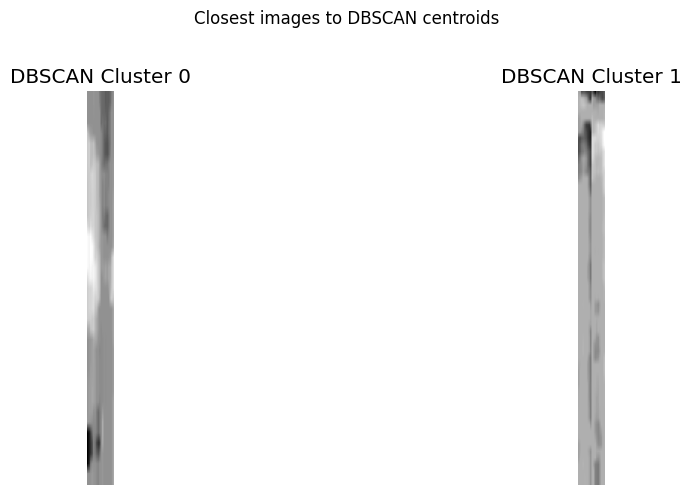

In [179]:
# Determina el número máximo de clusters para el tamaño del gráfico
max_clusters = max(n_clusters_dbscan, n_clusters_kmeans)

# Crear la figura para DBSCAN
fig_dbscan, axes_dbscan = plt.subplots(1, n_clusters_dbscan, figsize=(15, 5))

# Visualizar las imágenes de DBSCAN
for i in range(n_clusters_dbscan):
    ax = axes_dbscan[i]
    ax.imshow(closest_images_dbscan_reshaped[i], cmap='gray')
    ax.set_title(f'DBSCAN Cluster {i}')
    ax.axis('off')

fig_dbscan.suptitle('Closest images to DBSCAN centroids')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


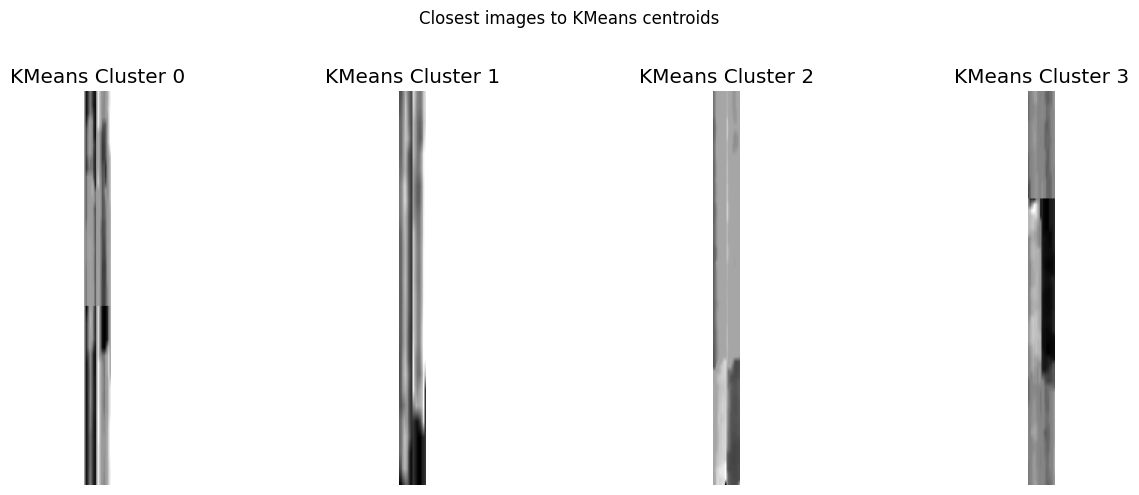

In [180]:
# Crear la figura para KMeans
fig_kmeans, axes_kmeans = plt.subplots(1, n_clusters_kmeans, figsize=(15, 5))

# Visualizar las imágenes de KMeans
for i in range(n_clusters_kmeans):
    ax = axes_kmeans[i]
    ax.imshow(closest_images_kmeans_reshaped[i], cmap='gray')
    ax.set_title(f'KMeans Cluster {i}')
    ax.axis('off')

fig_kmeans.suptitle('Closest images to KMeans centroids')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# NOK Cluster

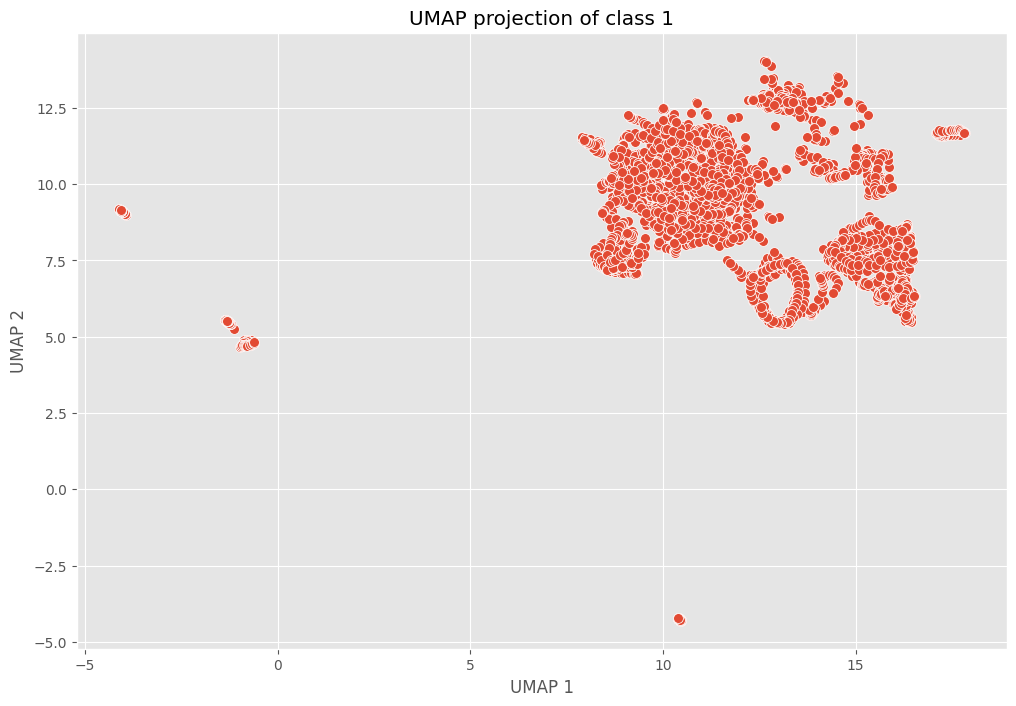

In [134]:
X_cluster_1 = X_umap[Y == 1]

# Graficar la clase 1
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], palette='viridis', s=50)
plt.title('UMAP projection of class 1')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

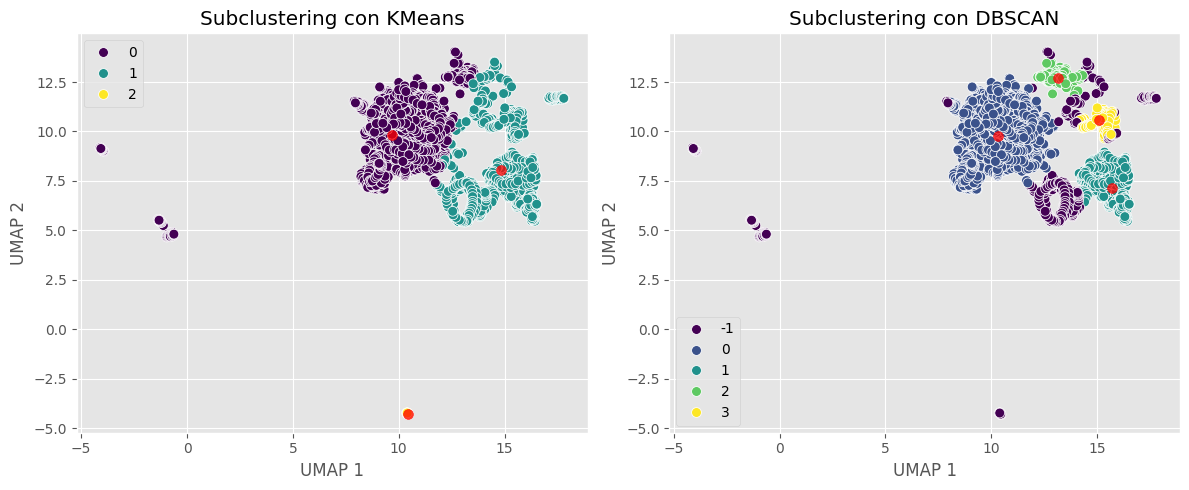

In [135]:
# Definir el número de clusters para KMeans
n_clusters_kmeans = 3  # Ajusta este valor según tus necesidades

# Crear el modelo KMeans
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_cluster_1)
centroids_kmeans = kmeans.cluster_centers_

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=150)  # Ajusta estos parámetros según tus necesidades
clusters_dbscan = dbscan.fit_predict(X_cluster_1)

# Obtener los baricentros de los clusters de DBSCAN (no todos los clusters tienen baricentros en DBSCAN)
centroids_dbscan = []
for label in set(clusters_dbscan):
    if label != -1:  # El cluster -1 en DBSCAN representa puntos ruido
        cluster_points = X_cluster_1[clusters_dbscan == label]
        centroid = cluster_points.mean(axis=0)
        centroids_dbscan.append(centroid)
centroids_dbscan = np.array(centroids_dbscan)

# Visualizar los resultados de KMeans
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], hue=clusters_kmeans, palette='viridis', s=50)
plt.scatter(centroids_kmeans[:, 0], centroids_kmeans[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con KMeans')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Visualizar los resultados de DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_cluster_1[:, 0], y=X_cluster_1[:, 1], hue=clusters_dbscan, palette='viridis', s=50)
if len(centroids_dbscan) > 0:
    plt.scatter(centroids_dbscan[:, 0], centroids_dbscan[:, 1], c='red', s=200, alpha=0.75, marker='.')
plt.title('Subclustering con DBSCAN')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.tight_layout()
plt.show()

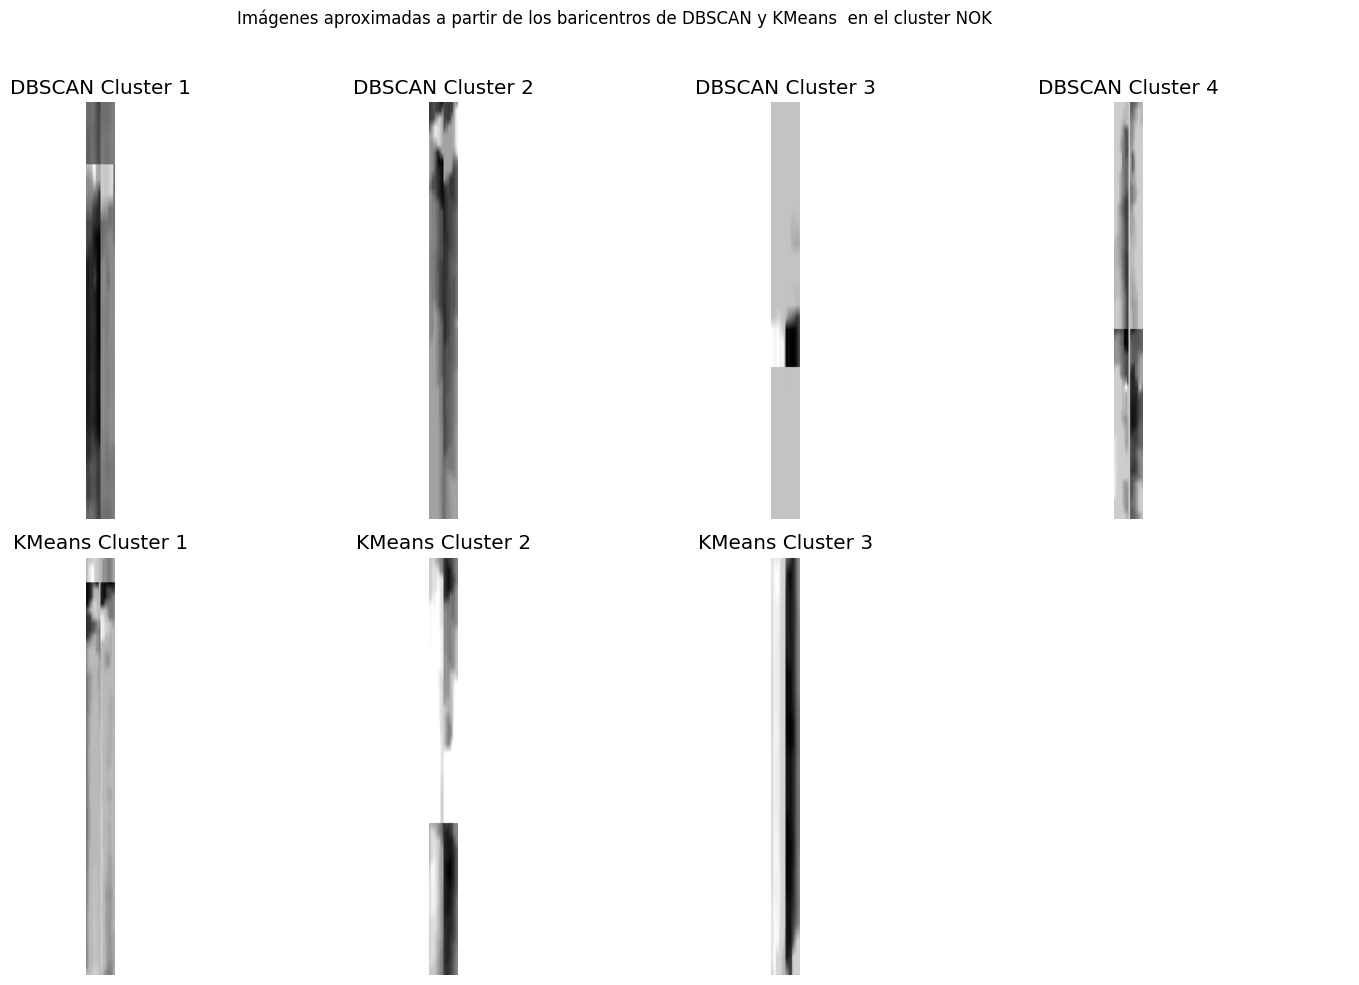

In [136]:
closest_dbscan, _ = pairwise_distances_argmin_min(centroids_dbscan, X_umap)
closest_images_dbscan = X[closest_dbscan]
closest_images_dbscan_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_dbscan])

# Identificar las imágenes más cercanas a cada centroide de KMeans
closest_kmeans, _ = pairwise_distances_argmin_min(centroids_kmeans, X_umap)
closest_images_kmeans = X[closest_kmeans]
closest_images_kmeans_reshaped = np.array([img.reshape((264, 18)) for img in closest_images_kmeans])

# Determinar el número de clusters para KMeans y DBSCAN
n_clusters_dbscan = closest_images_dbscan_reshaped.shape[0]
n_clusters_kmeans = closest_images_kmeans_reshaped.shape[0]

# Determinar el número máximo de clusters para el tamaño de la gráfica
max_clusters = max(n_clusters_dbscan, n_clusters_kmeans)

# Crear la figura con dos filas
fig, axes = plt.subplots(2, max_clusters, figsize=(15, 10))

# Visualizar las imágenes de los centroides DBSCAN en la primera fila
for i in range(max_clusters):
    ax = axes[0, i]
    if i < n_clusters_dbscan:
        ax.imshow(closest_images_dbscan_reshaped[i], cmap='gray')
        ax.set_title(f'DBSCAN Cluster {i+1}')
    ax.axis('off')

# Visualizar las imágenes de los centroides KMeans en la segunda fila
for i in range(max_clusters):
    ax = axes[1, i]
    if i < n_clusters_kmeans:
        ax.imshow(closest_images_kmeans_reshaped[i], cmap='gray')
        ax.set_title(f'KMeans Cluster {i+1}')
    ax.axis('off')

plt.suptitle('Imágenes aproximadas a partir de los baricentros de DBSCAN y KMeans  en el cluster NOK')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()